In [140]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import argparse
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.plotGraph as plotGraph
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import pandas as pd


printFlag= 1
plotFlag= 1

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
device= paras.device if torch.cuda.is_available() else "cpu"
#preset
paras.modelLoad= "AA"
paras.epoches= 20000
paras.strains = 3

Epi= "Sars_" # Sars, Covid, H1N1
Epi= "" # sars, covid, H1N1

# Read the CSV file into a NumPy array
epiOData = np.genfromtxt(f'testData/{Epi}test_data.csv', delimiter=',', skip_header=0)
popData = np.genfromtxt(f'testData/{Epi}test_pop.csv', delimiter=',', skip_header=0)
popIdxData = np.genfromtxt(f'testData/{Epi}test_pop_inx.csv', delimiter=',', skip_header=0)
popIdxData= [int(i) for i in popIdxData]
file_path = 'testData/Country_Population_final.csv'
data = pd.read_csv(file_path)
popName= data["Country"].tolist()
popIdxAll= data["idx"]
popCropArea= data["CropArea"].to_numpy()
curPopName= [popName[int(i)] for i in popIdxData]
# print(curPopName)
# scaling= popData[np.argmax(popData)]/popData
# print(scaling.shape)
print(epiOData.shape)
# epiOData= epiOData*scaling[None, :]
popData= popData/(popCropArea[popIdxData]/1e4+1e-9)
epiData= epiOData.copy()/popData[None, :]#[np.argmax(popData)]
# epiData= epiOData.copy()/popData[np.argmax(popData)]*popCropArea[popIdxData][None, :]/1e5
epiData[1:, :]= epiData[1:, :]- epiData[:-1, :]
epiData[epiData<0]= 0
epiData= epiData.T

epiData= np.stack([epiData[:, 0:30], epiData[:, 30:30*2], epiData[:, 30*2: 30*3]], axis= 1)
# print(epiData.shape)
# epiData= epiData[:, None, :]
# print(epiData.shape)
divide= torch.Tensor(epiData).to(device)
print(divide.shape)
paras.n= divide.shape[0]
P= torch.Tensor(popData).to(device)
# print(epiOData.shape)
# print(popData.shape)
# print(popIdxData.shape)
# print(len(popName))

# plt.figure(figsize=(12, 4))
# plt.plot(epiData)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(90, 92)
torch.Size([92, 3, 30])


torch.Size([92, 3, 30])


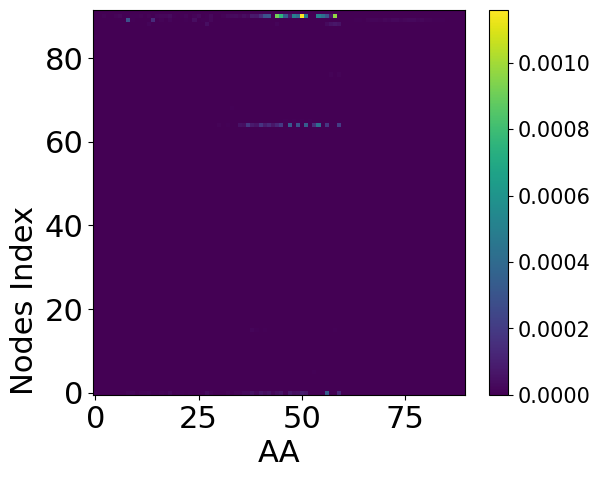

In [141]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)

shapeY= divide.shape[0]
shapeX= divide.shape[1]*divide.shape[2]
divide2D= divide.reshape(shapeY, shapeX).cpu().detach()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), divide2D)
cbar= fig.colorbar(cmap)

cbar.ax.tick_params(labelsize= fontsize-7)

plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)

plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [148]:

timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=3e-4)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr=3e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=3e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)
evaluateResults= []
PreZs= []
# divideSum= divide.sum(dim= 2)
# divideSum= divideSum.sum(dim= 1)
# maskZmat= torch.zeros(divideSum.shape[0], divideSum.shape[0]).to(device)
# maskZmat[divideSum<1e-10, :]= 1
# maskZmat[:, divideSum<1e-10]= 1
# print(maskZmat)

In [170]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]


for j in tqdm(range(paras.epoches*2)):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    inferZmat= myMatch(divide, paras.modelLoad)
    predSignal, signal, PreZ= myEpi(divide, inferZmat)
    normPre=torch.norm(predSignal, dim= 2)
    normTrue=torch.norm(signal, dim= 2)
    cosSim= torch.sum(torch.sum(predSignal*signal, dim= 2)/(normPre*normTrue+1e-8))
    loss= myloss(predSignal[:, :, 0:-1],signal[:, :, 1:])*1000  \
    + torch.var(myEpi.taus, dim= 0).sum() + torch.var(myEpi.R0dTaus, dim= 0).sum()/1e3
    if torch.isnan(loss).any():
        utils.log_print(printFlag, f"meet nan value at {j}")#
        break
    losses.append(loss.item())
    loss.backward(retain_graph=True)
    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

100%|██████████| 40000/40000 [02:12<00:00, 302.51it/s]


tensor(1.7007e-17, device='cuda:0', grad_fn=<DivBackward0>)


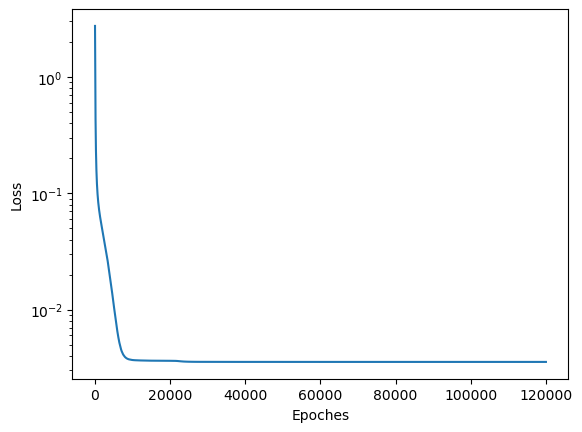

In [171]:
print(torch.var(myEpi.taus, dim= 0).sum()/1e7)
if plotFlag==1:
    plt.plot(losses)
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")

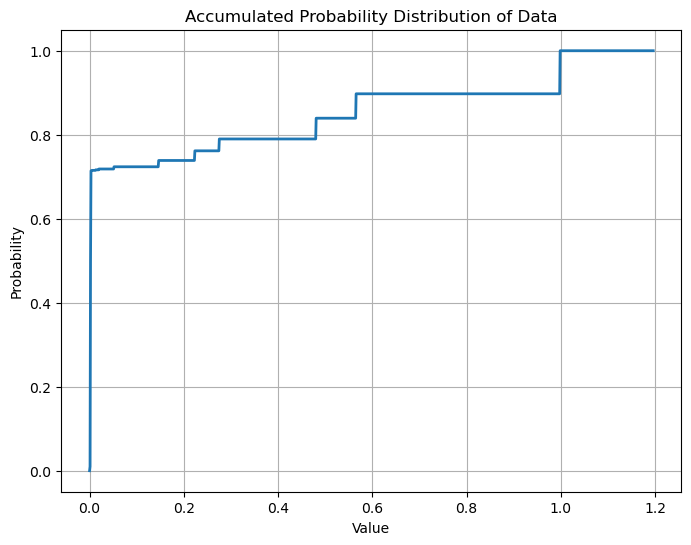

In [172]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()
pxs= []
pys= []
# Compute histogram
for i in range(1200):
    px= i*(np.max(inferZmatNp)-np.min(inferZmatNp))/1000
    py= np.sum(inferZmatNp[inferZmatNp<px])/np.sum(inferZmatNp)
    pxs.append(px)
    pys.append(py)
    pass

# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

In [173]:
printFlag= 1
# #save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
utils.log_print(printFlag,1/myEpi.taus.T) # recoverry rate
utils.log_print(printFlag,(myEpi.R0dTaus).T)# transmission rate
#H1N1:(0.1677, 0.1849), Sars: (0.1630, 0.1578), Covid: (0.1873, 0.3838)
IMatrix= torch.eye(paras.n, device= device)
# print(inferZmat)
PreA= A_mat.reverse_A_mat(inferZmat, P)
utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))


tensor([[0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471, 0.1471,
         0.1471, 0.1471],
        [0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025,
         0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025, 0.2025,
  

tensor([0.0000e+00, 1.0447e-03, 1.1347e-03, 1.0579e-03, 1.0955e-03, 1.2754e-03,
        1.0579e-03, 1.0588e-03, 1.1402e-03, 1.0664e-03, 1.0579e-03, 1.0579e-03,
        1.0615e-03, 1.0930e-03, 1.0579e-03, 9.9748e-01, 1.0579e-03, 1.0579e-03,
        1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03,
        1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03,
        1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03,
        1.0579e-03, 1.0579e-03, 1.4331e-03, 1.0579e-03, 1.3000e-03, 1.0579e-03,
        1.1685e-03, 1.0607e-03, 1.0579e-03, 1.0596e-03, 1.0579e-03, 1.0579e-03,
        1.0589e-03, 1.0579e-03, 1.0845e-03, 1.0690e-03, 1.1408e-03, 1.0579e-03,
        1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03, 1.0579e-03,
        1.0579e-03, 1.0734e-03, 1.0605e-03, 1.0579e-03, 5.6521e-01, 1.1792e-03,
        6.2420e-04, 1.0449e-03, 1.5800e-03, 1.0532e-03, 1.0576e-03, 1.0848e-03,
        4.3623e-03, 1.0556e-03, 1.0623e-

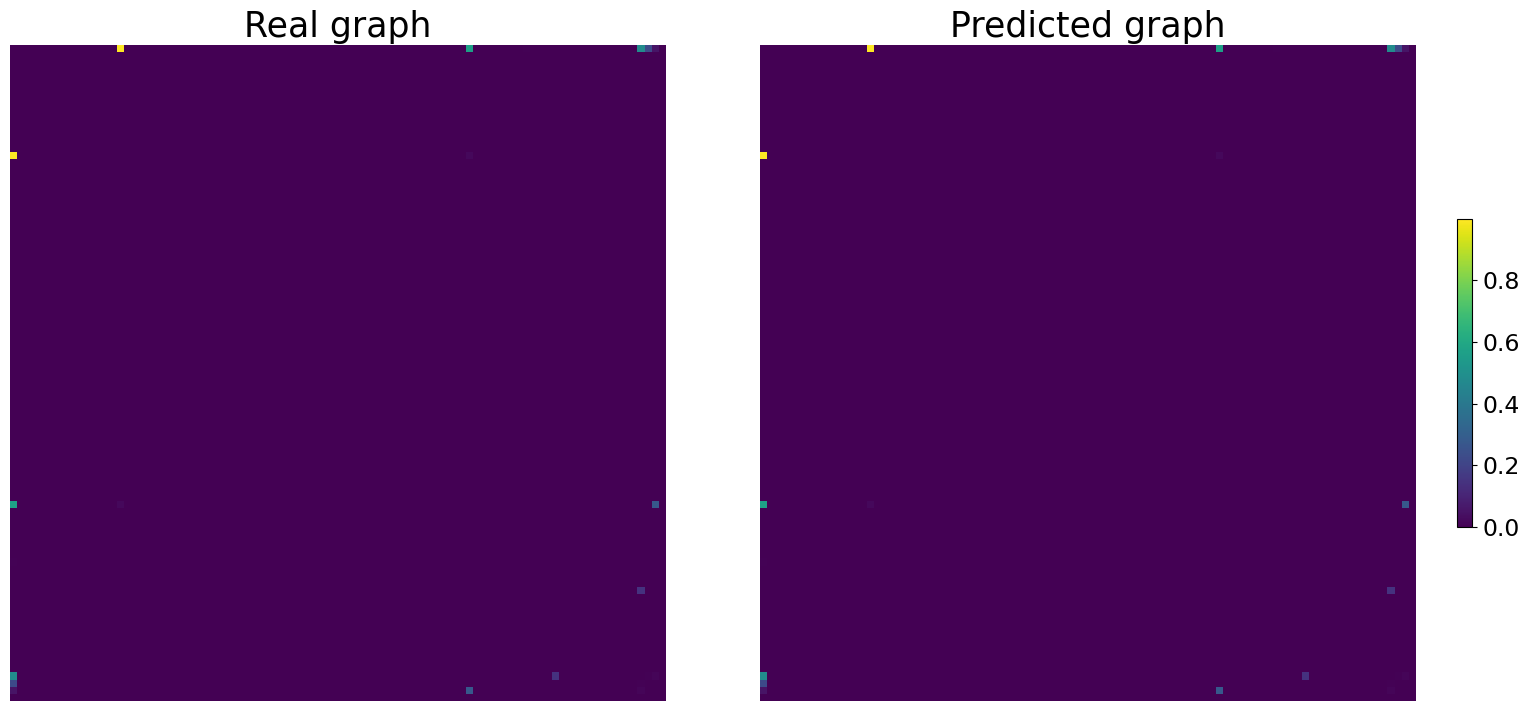

[65  5 68 77 75 38 72 66  2 42 84  4 67 52 61 86 13  1 78 40  8 12 45 85
 48 50  7  9 51 71 79 74 82 47 73 70 81 69 43 80 83 28 56 60 57 55 63 91
 29 10 11 14 16 17 19 20 21 22 23 24 27  6 30  3 37 39 32 36 35 33 34 25
 59 44 54 53 31 41 46 58 49 18 87 26 62 76 89 90 88 64 15  0]
['Panama', 'United Kingdom', 'New Zealand', 'Colombia', 'Brazil', 'France', 'Japan', 'Costa Rica', 'Germany', 'Italy', 'Thailand', 'Finland', 'El Salvador', 'Turkey', 'Guatemala', 'Malaysia', 'Sweden', 'Belgium', 'Russia', 'Greece', 'Ireland', 'Norway', 'Israel', 'Vietnam', 'Portugal', 'Romania', 'Netherlands', 'Denmark', 'Switzerland', 'Taiwan', 'India', 'Philippines', 'Hong Kong', 'Austria', 'South Korea', 'United Arab Emirates', 'Cambodia', 'Iran', 'Slovenia', 'Sri Lanka', 'Nepal', 'Libya', 'Serbia', 'Dominican Republic', 'Montenegro', 'Gibraltar', 'Jamaica', 'Wake Island', 'Rwanda', 'Faroe Islands', 'Luxembourg', 'Seychelles', 'Sierra Leone', 'Liberia', 'Senegal', 'Mauritania', 'Guinea', 'Cape Verde', 'Eth

In [174]:
toShowTopology= inferZmat
print(inferZmat[0])
if plotFlag==1:
    plotGraph.plot_adjacenty(toShowTopology.cpu().detach().numpy(), [ toShowTopology.cpu().detach().numpy()])
sumDegree= toShowTopology.cpu().detach().numpy().sum(axis= 1)
rankedPreAdegree= np.argsort(sumDegree)
print(rankedPreAdegree)
print([curPopName[i] for i in rankedPreAdegree])
print(curPopName)

(92,)


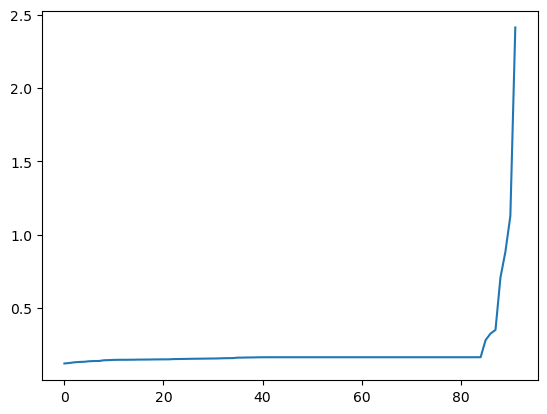

In [175]:
print(popData.shape)
plt.plot(sumDegree[rankedPreAdegree])

In [176]:
print(curPopName.index("Canada"))

0


torch.Size([92, 3, 30])


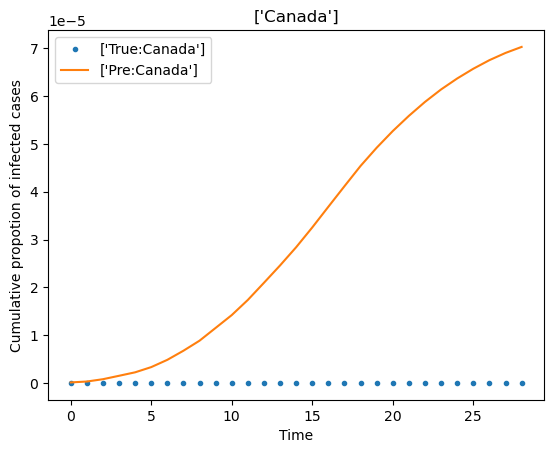

In [182]:
if plotFlag==1:
    node= [0]# -28
    refEpi= np.cumsum(signal[node, 2, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    preEpi= np.cumsum(predSignal[node, 2, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    plt.plot(refEpi, ".", label=["True:"+curPopName[i] for i in node])
    plt.plot(preEpi, label= ["Pre:"+curPopName[i] for i in node])
    plt.title(f"{[curPopName[i] for i in node]}")
    plt.xlabel("Time")
    plt.ylabel("Cumulative propotion of infected cases")
    plt.legend()
    print(signal.shape)


In [90]:
from geopy.geocoders import Nominatim

# List of states and locations
locations = popName

# Initialize geolocator
geolocator = Nominatim(user_agent="geo_locator")

# Dictionary to store results
coordinates = {}
coordinatesList = []

# Get coordinates for each location
for location in locations:
    try:
        loc = geolocator.geocode(location, featuretype="country")
        if loc:
            coordinates[location] = (loc.latitude, loc.longitude)
        else:
            loc = geolocator.geocode(location)
            coordinates[location] = (loc.latitude, loc.longitude)  # If location not found
            print("Not a country:", location)
    except Exception as e:
        coordinates[location] = (0, 0)  # Handle errors gracefully
        print(location)
    coordinatesList.append([coordinates[location][0], coordinates[location][1]])


Not a country: Saint Helena
Not a country: Mayotte
Not a country: Reunion
Not a country: Saint Pierre and Miquelon
Not a country: Wallis and Futuna
Not a country: American Samoa
Not a country: French Polynesia
Not a country: New Caledonia
Not a country: Northern Mariana Islands
Not a country: Guam
Not a country: Midway Islands
Not a country: Antarctica
Not a country: French Guiana
Not a country: Martinique
Not a country: Guadeloupe
Not a country: Puerto Rico
Not a country: Aruba
Not a country: Netherlands Antilles
Not a country: Hong Kong
Not a country: Macau
Not a country: Christmas Island
Not a country: Norfolk Island
Not a country: Palestine
Not a country: Johnston Atoll
Not a country: Western Sahara
Not a country: Cocos (Keeling) Islands
Not a country: Wake Island


In [183]:
popIdxDataNp= np.array(popIdxData, dtype= "int")
coordinatesArrayTmp= np.array(coordinatesList)#[np.array(popIdxData, dtype= "int"), :]

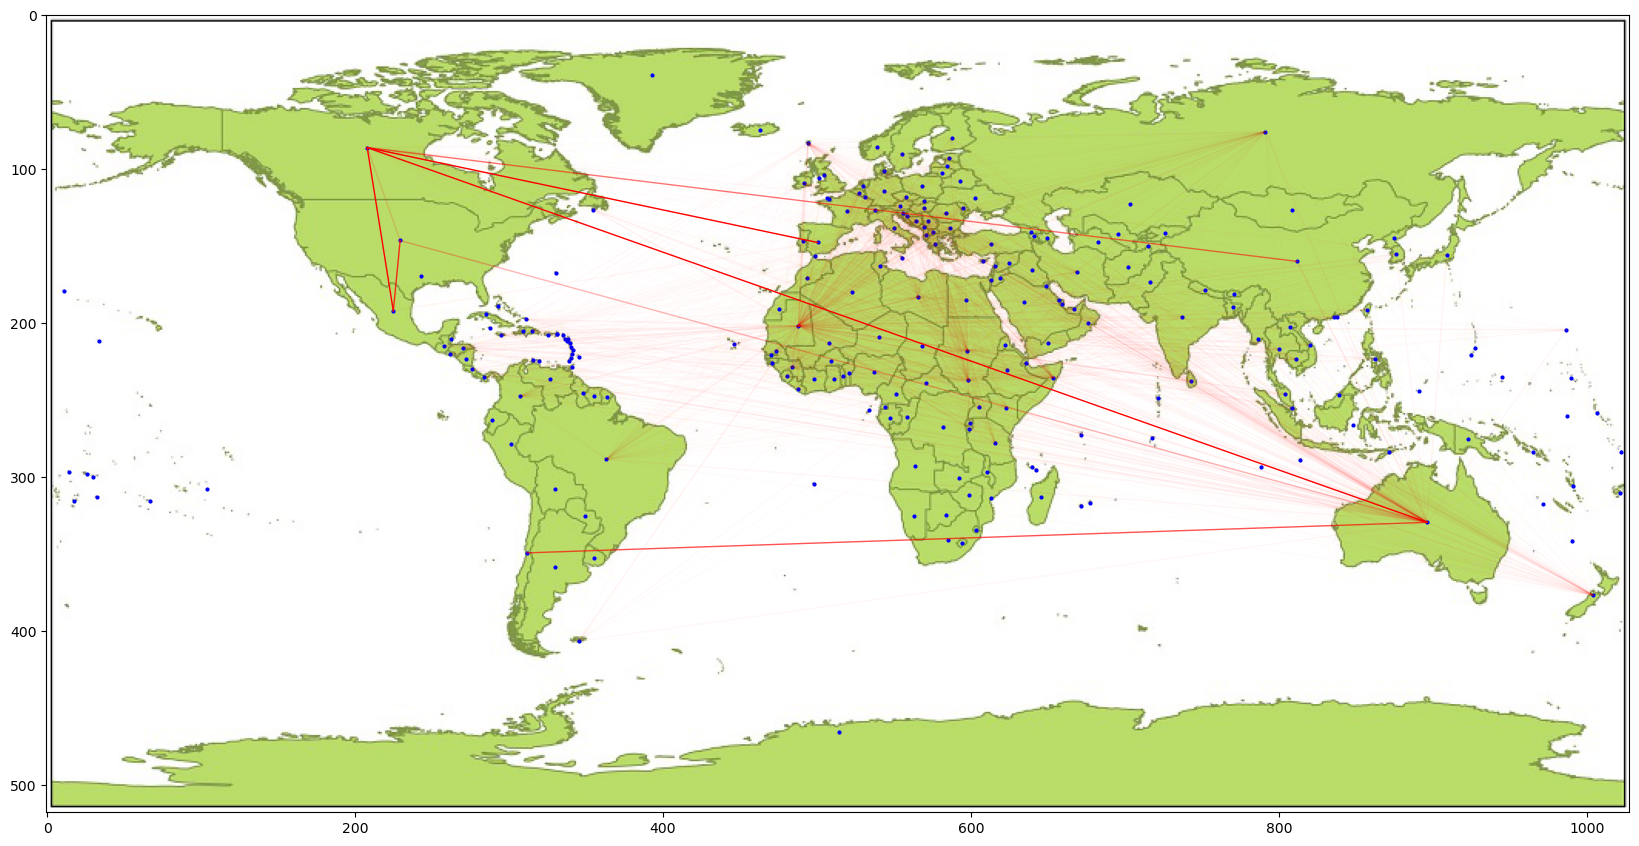

In [184]:
plt.figure(figsize=(10.28*2, 5.18*2))
img = plt.imread("WorldEqdc.jpg")
plt.imshow(img)
coordinatesArray= coordinatesArrayTmp.copy()
coordinatesArray[:, 1]= 2.835*coordinatesArrayTmp[:, 1]+1028/2
coordinatesArray[:, 0]= -2.835*coordinatesArrayTmp[:, 0]+518/2
plt.scatter(coordinatesArray[:, 1], coordinatesArray[:, 0], color='blue', s=4, label="Locations")
# for i in popIdxDataNp[:]:
#     plt.text(coordinatesArray[i, 1] + 0.1,
#             coordinatesArray[i, 0] + 0.1, f"{popName[i]}", fontsize=10, color='black')  # Annotate points
PreANp= PreA.cpu().detach().numpy()
for i in range(PreANp.shape[0]):
    for j in range(i + 1, PreANp.shape[1]):  # Only upper triangle (undirected graph)
        if (PreANp[i, j]+PreANp[j, i])/2 > 1e-3 :# Only plot edges with weight > 0
            weight = (PreANp[i, j]+PreANp[j, i])/2
            plt.plot(
                [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                color='red', alpha=min(weight*4, 1), linewidth= 1
            )